Всем привет!


Сегодня мы поговорим о визуализации геоданных. Имея на руках статистику, явно имеющую пространственную привязку, всегда хочется сделать красивую карту. Желательно, с навигацией, инфоокнами и всплывающими подсказками. В тетрадках. И чтоб потом можно было показать всему интернету свои успехи в визуализации!

В качестве примера возьмем недавно отгремевшие муниципальные выборы в Москве. Сами данные можно взять с сайта мосгоризбиркома, в можно просто забрать датасеты с https://gudkov.ru/. Там даже есть какая-никакая визуализация, но мы пойдем глубже. Итак, что же у нас в итоге должно получиться?

Потратив некоторое время на написание парсера сайта Избиркома, я получил нужные мне данные. Итак, начнем с импортов.

In [2]:
import pandas as pd
import numpy as np
import os
import pickle

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
os.environ["http_proxy"] = "http://192.168.130.151:81"
os.environ["https_proxy"] = "https://192.168.130.151:81"

Я работаю в jupyter notebook на Linux-машине. Если вы захотите использовать мой код на Windows машине, то обращайте внимание на написание путей, а также на важные отступления в тексте.

Обычно я использую отдельную папку для проекта, поэтому для простоты задаю текущую директорию:

In [4]:
os.chdir('/data01/jupyter/notebooks/habr/ods_votes/')

Дальше нам трубуется забрать данные с самого сайта Избиркома. Для разбора данных я написал отдельный парсер. Весь процесс занимает 10-15 минут. Забрать его можно из репозитория https://github.com/fall-out-bug/izbirkom_parser

Я решил создать большой словарь с датафреймами внутри. Для превращения html-страниц в датафреймы я использовал read_html, эмпирически подбирал нужные датафрейс, а после этого делал небольшую обработку, выкидывая лишнее и добавляя недостающее. Предварительно я уже обработал данные по партиям. Изначально они были не особо читаемы. К тому же, встречается разное написание одних и тех же партий (забавно, но в некоторых случаях это не разное написание, а реально разные партии).

## Разбор данных избиркома

Непосредственно сборка справочника. Что здесь происходит:
* собираются структура административных и муниципальных округов;
* собираются все ссылки на Территориальные Избирательные Комиссии (ТИК);
* для каждого ТИК собирается список кандидатов;
* внутри каждого ТИК собираются Окружные Избирательные Комиссии (ОИК);
* для каждого ОИК собирается статистика по ОИК и статистика по кандидатам.

В репозитории этой статьи лежат уже готовые данные. Их мы и будем использовать.

In [7]:
import glob

# забираем справочник сокращений для партий
with open('tmp/party_aliases.pkl', 'rb') as f:
    party_aliases = pickle.load(f)

votes = {}
# забираем список округов и мунициальных образований
votes['atd'] = pd.read_csv('tmp/atd.csv', index_col=0, sep=';')
votes['data'] = {}
# идем по мунициальным образованиям и собираем статистику ТИК
for v in votes['atd']['municipal'].values:
    votes['data'][v] = {}
    # забираем статистику по кандидатам
    candidates = glob.glob('tmp/data_{}_candidates.csv'.format(v))[0]
    votes['data'][v]['candidates'] = pd.read_csv(candidates, index_col=0, sep=';')
    votes['data'][v]['votes'] = {}
    # теперь по каждому ОИК собираем его статистику
    # статистика по УИК
    okrug_stats_list = glob.glob('tmp/data_{}*_okrug_stats.csv'.format(v))
    for okrug_stats in okrug_stats_list:
        okrug = int(okrug_stats.split('_')[2])
        try:
            votes['data'][v]['votes'][okrug]
        except:
            votes['data'][v]['votes'][okrug] = {}
        votes['data'][v]['votes'][okrug]['okrug_stats'] = pd.read_csv(okrug_stats, index_col=0, sep=';')
    # статистика по кандидатам
    candidates_stats_list = glob.glob('tmp/data_{}*_candidates_stats.csv'.format(v))
    for candidates_stats in candidates_stats_list:
        okrug = int(candidates_stats.split('_')[2])
        votes['data'][v]['votes'][okrug]['candidates_stats'] = pd.read_csv(candidates_stats, index_col=0, sep=';')

# теперь собираем статистику в удобной нам форме
data = []

# пройдемся по муниципальным округам
for okrug in list(votes['data'].keys()):

    #чистим данные
    candidates = votes['data'][okrug]['candidates'].replace(to_replace={'party':party_aliases})
    group_parties = candidates[['party','elected']].groupby('party').count()

    # создаем общую статистику по избирателям
    stats = np.zeros(shape=(12))
    for oik in votes['data'][okrug]['votes'].keys():
        stat = votes['data'][okrug]['votes'][oik]['okrug_stats'].iloc[:,1]
        stats += stat

    # создаем статистику по партиям
    # количество мест
    sum_parties = group_parties.sum().values[0]

    # количество полученных мест
    data_parties = candidates[['party','elected']].groupby('party').count().reset_index()

    # процент полученных мест
    data_parties['percent'] = data_parties['elected']/sum_parties*100

    # собираем итоговую таблицу по округу
    tops = data_parties.sort_values('elected', ascending=False)
    c = pd.DataFrame({'okrug':okrug}, index=[0])
    c['top1'], c['top1_elected'], c['top1_percent'] = tops.iloc[0,:3]
    c['top2'], c['top2_elected'], c['top2_percent'] = tops.iloc[1,:3]
    c['top3'], c['top3_elected'], c['top3_percent'] = tops.iloc[2,:3]
    c['voters_oa'], c['state_rec'], c['state_given'], c['state_anticip'], c['state_out'], c['state_fired'], c['state_box'], c['state_move'], c['state_error'], c['state_right'], c['state_lost'] , c['state_unacc'] = stats 
    c['voters_percent'] = (c['state_rec'] - c['state_fired'])/c['voters_oa']*100
    c['total'] = sum_parties
    c['full'] = (c['top1_elected'] == sum_parties)

    # добавляем полученный датафрейм в список
    data.append(c)

# создаем итоговый датафрейм
winners = pd.concat(data,axis=0)

Мы получили датафрейм со статистикой явки, бюллютеней (от количества выданных до количества испорченных), распределением мест между партиями.
Можно приступать к визуализации!

## Базовая работа с геоданными в geopandas

Для работы с геоданными мы будем использовать библиотеку geopandas. Что такое geopandas? Это расширение функциональности pandas географическими абстракциями (унаследованными из Shapely), которые позволяют нам проводит аналитические географические операции с геоданными: выборки, оверлей, аггрегация (как, например, в PostGIS для Postgresql).

Напомню, что существует три базовых типа геометрии - точка, линия (а точнее, полилиния, так как состоит из соединенных отрезков) и полигон. У всех у них бывает вариант мульти-(Multi), где геометрия представляет собой объединение отдельных географических образований в один. Например, выход метро может быть точкой, но несколько выходов, объединенных в сущность "станция", уже являются мультиточкой.

>**Важное отступление**  
Следует обратить внимание, что geopandas неохотно ставится через pip в стандартной установке Python в среде Windows. Проблема, как обычно, в зависимостях. Geopandas опирается на абстракции библиотеки fiona, у которой нет официальных сборок под Windows. Идеально использовать среду Linux, например, в docker-контейнере. Кроме того, в Windows можно использовать менеджер conda, он все зависимости подтягивает из своих репозиториев.

C геометрией муниципальных образований все достаточно просто. Их можно легко забрать из OpenStreetMap (подробнее тут: https://habrahabr.ru/post/270513/) или, например, из выгрузок NextGIS (http://nextgis.ru/services/dataosm/). Я использую уже готовые шейпы.

Итак, начнем! Выполняем нужные импорты, активируем графики matplotlib...

In [10]:
import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('atd/mo.shp')
mo_gdf.head()

NAME     OKATO     OKTMO         NAME_AO  OKATO_AO  \
0         Киевский  45298555  45945000        Троицкий  45298000   
1   Филёвский Парк  45268595  45328000        Западный  45268000   
2  Новофёдоровское  45298567  45954000        Троицкий  45298000   
3        Роговское  45298575  45956000        Троицкий  45298000   
4     "Мосрентген"  45297568  45953000  Новомосковский  45297000   

        ABBREV_AO              TYPE_MO  \
0        Троицкий            Поселение   
1             ЗАО  Муниципальный округ   
2        Троицкий            Поселение   
3        Троицкий            Поселение   
4  Новомосковский            Поселение   

                                            geometry  
0  (POLYGON ((36.8031012 55.4408329, 36.8031903 5...  
1  POLYGON ((37.4276499 55.7482092, 37.4284863 55...  
2  POLYGON ((36.8035692 55.4516224, 36.8045117 55...  
3  POLYGON ((36.9372397 55.2413907, 36.9372604 55...  
4  POLYGON ((37.4395575 55.6273129, 37.4401803 55...

Как видите, это привычный DataFrame. Поле geometry - представление географических объектов (в данном случае - полигонов) в виде WKT, well known text (подробнее - https://en.wikipedia.org/wiki/Well-known_text). Можно довольно просто построить карту наших объектов.

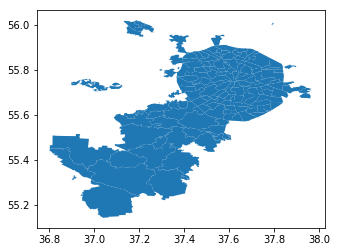

In [11]:
mo_gdf.plot()

Угадывается Москва! Правда, не совсем привычо выглядит. Причина в проекции карты. На Хабре уже есть отличный ликбез по ним: https://habrahabr.ru/post/235283/

Итак, представим наши данные в более привычной проекции Web Mercator (исходную проекцию можно легко получить по параметру crs). Окрасим полигоны по названию Административного округа. Ширину линий выставим 0,5. Метод окраски cmap использует стандартные значения matplotlib (если вы, как и я, не помните их наизусть, то вот шпаргалка: http://matplotlib.org/users/colormaps.html). Чтобы увидеть легенду карты,  задаем параметр legend. Ну а figsize отвечает за размер нашей карты.

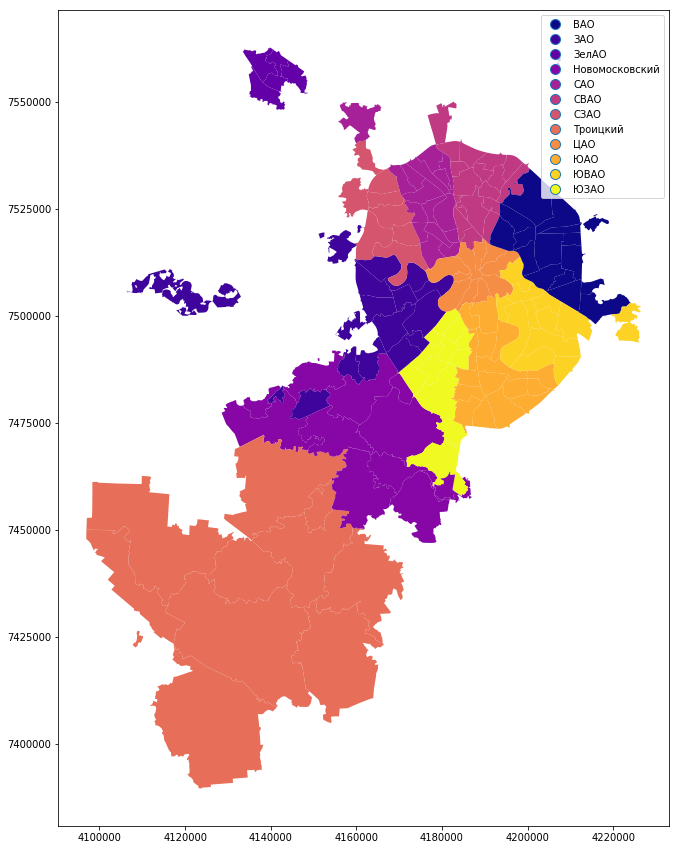

In [12]:
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

Можно построить карту и по типу муниципального образования:

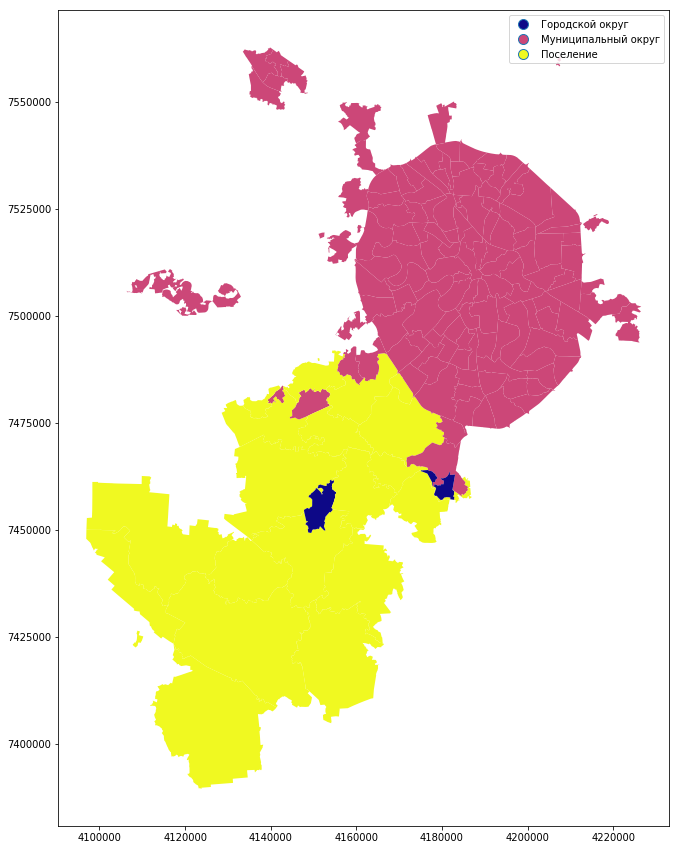

In [13]:
mo_gdf_wm.plot(column = 'TYPE_MO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

Итак, построим карту статистики по муниципальным округам. Ранее мы уже создали датафрейм winners.

Нам необходимо соединить наш датафрейм с геодатафреймом для создания карты. Немного причешем названия мунициальных округов, чтобы соединение произошло без сюрпризов.

In [14]:
winners['municipal_low'] = winners['okrug'].str.lower()
winners['municipal_low'] = winners['municipal_low'].str.replace('ё', 'е')
mo_gdf_wm['name_low'] = mo_gdf_wm['NAME'].str.lower()
mo_gdf_wm['name_low'] = mo_gdf_wm['name_low'].str.replace('ё', 'е')

In [15]:
full_gdf = winners.merge(mo_gdf_wm[['geometry', 'name_low']], left_on='municipal_low', right_on='name_low', how='left')
full_gdf = gpd.GeoDataFrame(full_gdf)

Построим простую категориальная карту, где от зеленого к синему распределены партии-победители. В районе Щукино в этом году и правда не было выборов.

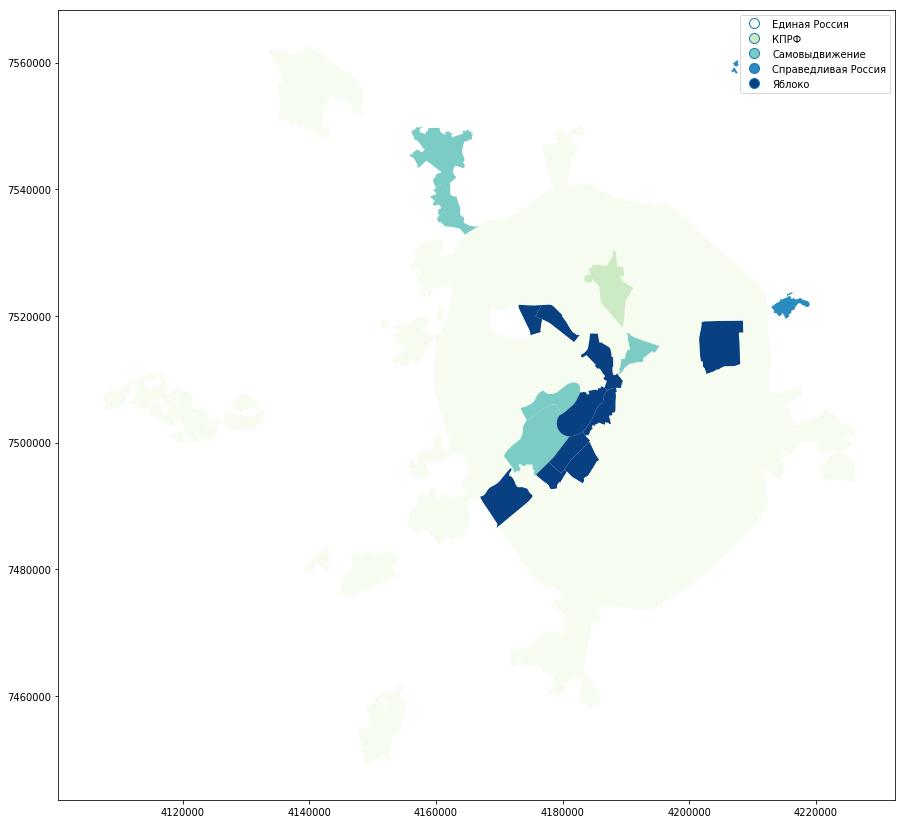

In [18]:
full_gdf.plot(column = 'top1', linewidth=0, cmap='GnBu', legend=True, figsize=[15,15])

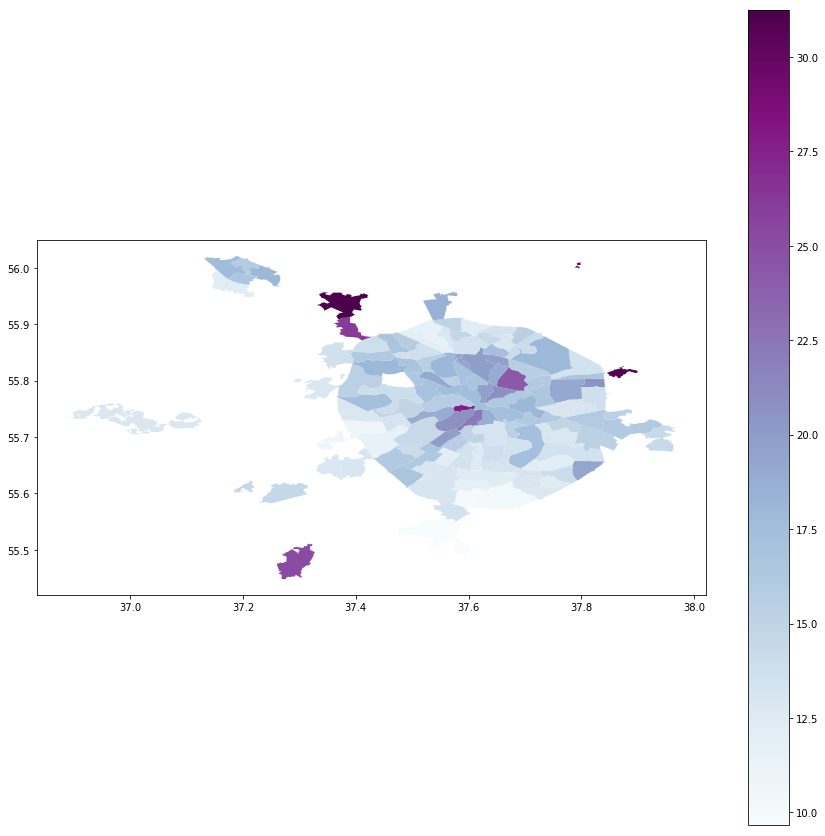

In [38]:
full_gdf.plot(column = 'voters_percent', linewidth=0, cmap='BuPu', legend=True, figsize=[15,15])

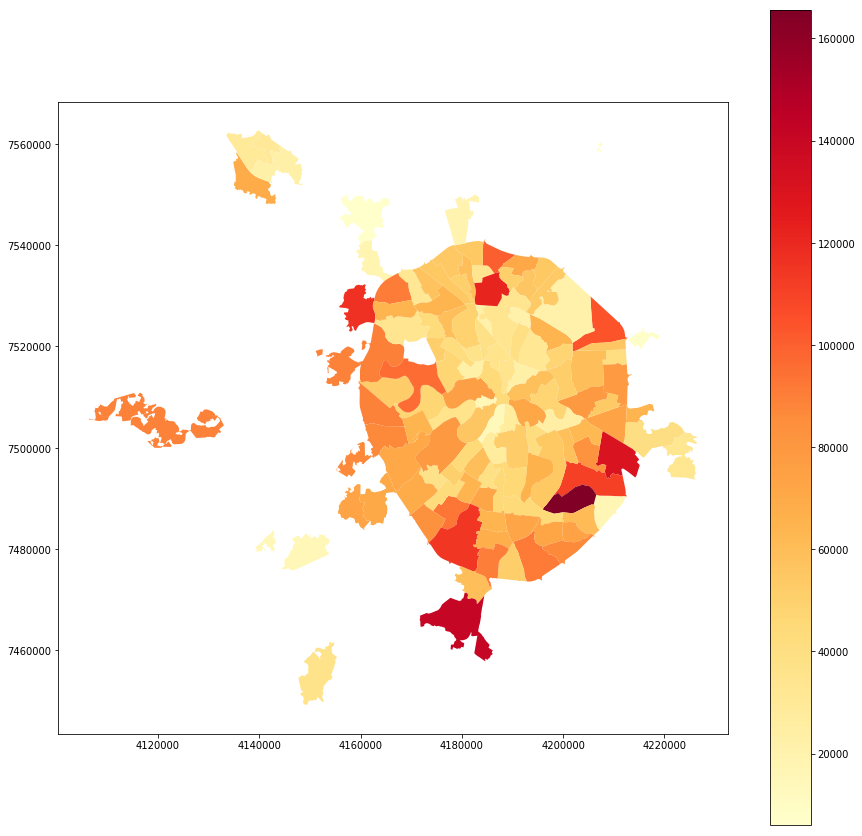

In [20]:
full_gdf.plot(column = 'voters_oa', linewidth=0, cmap='YlOrRd', legend=True, figsize=[15,15])

Отлично! У нас получилась симпатичная визуализация. Но хочется и базовую карту, и навигацию, и инфоокна! На помощь нам придет библиотека cartoframes

## Визуализация геоданных с помощью cartoframes

Одним из самых удобных инструментов для визуализации геоданных является Carto. Для работы с этим сервисом существуюет библиотеке cartoframes, которая позволяет работать с функциями сервиса прямо из тетрадок Jupyter.

> **Важное отступление**  
Библиотека cartoframes требует внимательного обращения под Windows в силу особенностей разработки. С кириллическими данными можно легко отстрелить себе ногу. Лучше ее использовать или в docker-контейнере, или на полноценном Linux. Ставится библиотека только через pip. В windows ее можно успешно установить, предварительно поставив geopandas через conda (или поставив все зависимости руками).

Cartoframes работает с проекцией WGS84. В нее и перепроецируем наш датасет. После соединения двух датафреймов может теряться информация о проекции. Зададим ее заново и перепроецируем.

In [21]:
full_gdf.crs = ({'init' :'epsg:3857'})
full_gdf = full_gdf.to_crs({'init' :'epsg:4326'})

Делаем нужные импорты...

In [23]:
import cartoframes
import json
import warnings
warnings.filterwarnings("ignore")

Добавляем данные от аккаунта Carto:

In [25]:
USERNAME = 'zhukov'
APIKEY = 'bbb8957d171e21e30601d0152d381d5cbfaae3eb'

И, наконец, подключаемся к Carto и заливаем наш датасет:

In [26]:
cc = cartoframes.CartoContext(api_key=APIKEY, base_url='https://{}.carto.com/'.format(USERNAME))

In [27]:
cc.write(full_gdf, encode_geom=True, table_name='mo_votes', overwrite=True)

Table successfully written to CARTO: https://zhukov.carto.com/dataset/mo_votes


Датасет можно выгрузить с Carto обратно. Увы, полноценный геодатафрейм пока только в проекте. Можно с помощью gdal и shapley сконвертировать бинарное представление геометрии PostGIS снова в WKT.

Наконец, карта! Разукрасим данные, положим на базовую карту и включим навигацию. Подсмотреть схемы окрашивания можно здесь :https://github.com/CartoDB/CartoColor/wiki/CARTOColor-Scheme-Names

In [28]:
query_layer = 'select cartodb_id, the_geom, the_geom_webmercator, voters_oa::float, voters_percent::float, state_out::float from mo_votes'

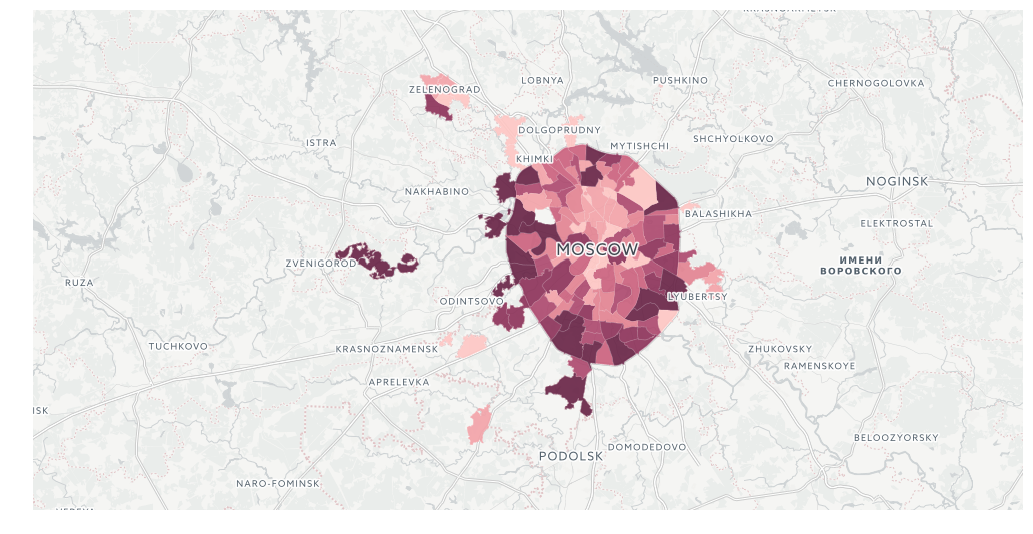

In [29]:
from cartoframes import Layer, BaseMap, styling, QueryLayer
l = QueryLayer(query_layer, color={'column': 'voters_oa', 'scheme': styling.burg(bins=7)})
map = cc.map(layers=[BaseMap(source='light', labels='front'), l], size=(990, 500), interactive=False)

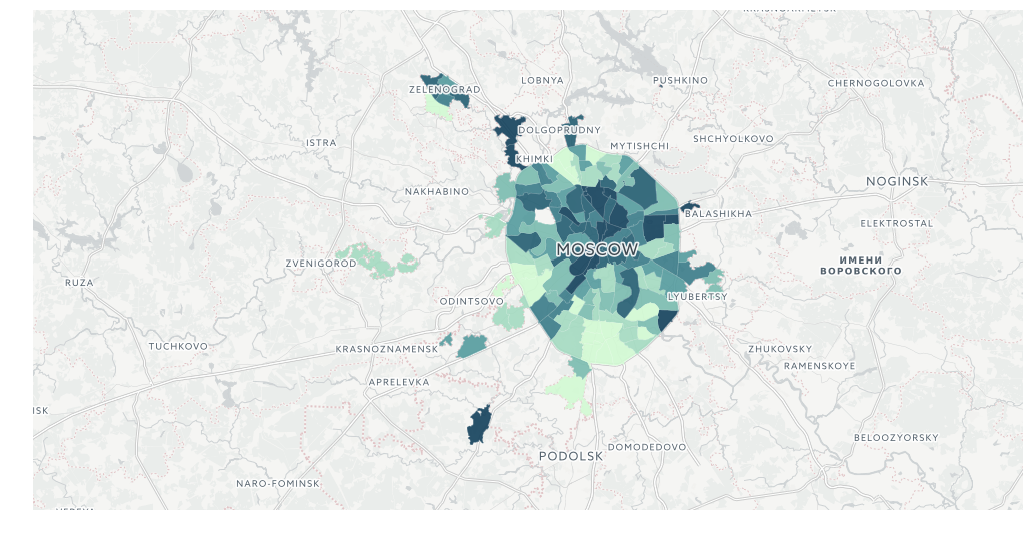

In [30]:
l = QueryLayer(query_layer, color={'column': 'voters_percent', 'scheme': styling.darkMint(bins=7)})
map = cc.map(layers=[BaseMap(source='light', labels='front'), l], size=(990, 500), interactive=False)

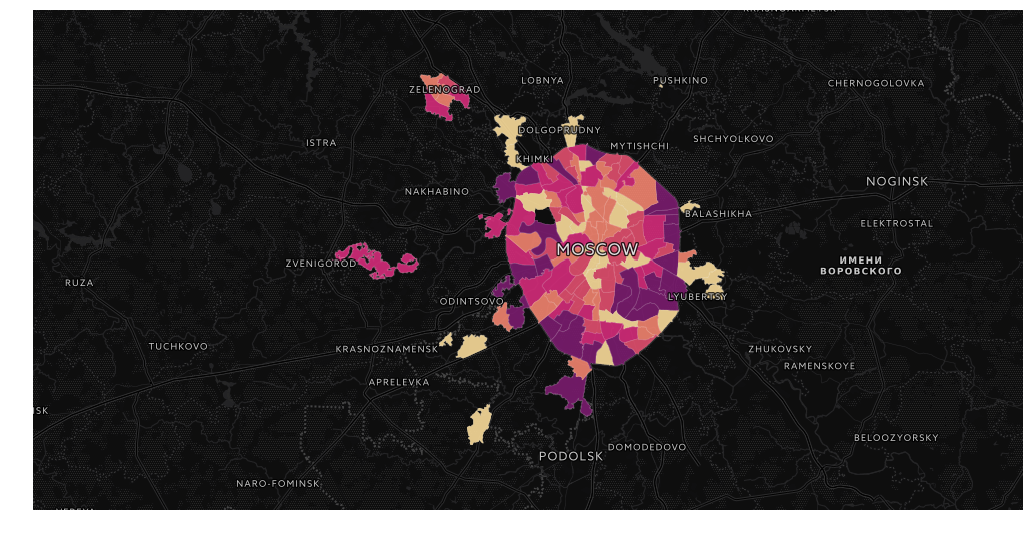

In [31]:
l = QueryLayer(query_layer, color={'column': 'state_out', 'scheme': styling.sunsetDark(bins=5)})
map = cc.map(layers=[BaseMap(source='dark', labels='front'), l], size=(990, 500), interactive=False)

Следует заметить, что в данный момент cartoframes не позволяет встроить инфоокна прямо в окно тетрадки, показывать легенду, а также публиковать карты на Carto. Но эти опции в процессе имплементации.

Итоговый результат в самом Carto может выглядеть вот так:

In [ ]:
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://zhukov.carto.com/builder/66ca6e98-5dcd-478c-b5a9-9efd5c74d872/embed" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

# Визуализация геоданных с помощью folium

Итак, нам хотелось бы получить не только навигацию, но и инфоокна на карте. А еще получить возможность публикации визуализации на своем сервере или на github. Нам поможет folium.

> **Важное отступление**  
Библиотека folium - довольно специфичная штука. Она представляет собой python-обертку вокруг JS-библиотеки Leaflet, которая как раз и отвечает за картографическую визуализацию. Следующие манипуляции выглядят не очень pythonic, но не пугайтесь, я все поясню

In [34]:
import folium

Простая визуализация наподобие Carto делается достаточно просто.

Что происходит?  
* мы создаем инстанс карты, m, с центром в выбранных координатах;
* добавляем инстанс картограммы (choropleth)

В инстансе картограммы мы задаем много атрибутов:  
* geo_data - геоданные, мы конвертируем данные нашего датафрейма в geojson;
* name - задаем имя слоя;
* data - непосредственно данные, их мы выбираем тоже из датафрейма;
* key_on - ключ для соединения (обратите внимание, в geojson все атрибуты сложены в отдельный элемент, properties);
* columns - ключ и атрибут для раскрашивания;
* fill_color, fill_opacity, line_weight, line_opacity  - цветовая шкала заливки, прозрачность заливки, ширина и прозрачность линий;
* legend_name - заголовок легенды;
* highlight  - добавление интерактива (подсветки при наведении и приближения при клике) у объектов.

Цветовая шкала основывается на библиотеке Color Brewer: http://colorbrewer2.org. Я крайне рекомендую при работе с картами пользоваться ей.

In [47]:
m = folium.Map(location=[55.764414, 37.647859])
m.choropleth(
    geo_data=full_gdf[['okrug', 'geometry']].to_json(),
    name='choropleth',
    data=full_gdf[['okrug', 'voters_oa']],
    key_on='feature.properties.okrug',
    columns=['okrug', 'voters_oa'],
    fill_color='YlGnBu',
    line_weight=1,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='type',
    highlight = True
)
m

Итак, у нас получилась интерактивная картограмма. Но хотелось бы и инфоокон...
Здесь нам придется немного хакнуть библиотеку.

Итак, у нас есть партии-победители в каждом ТИК. Для каждой из них мы определим базовый цвет.

In [59]:
print(set(full_gdf['top1'].values))

{'Самовыдвижение', 'Яблоко', 'Единая Россия', 'КПРФ', 'Справедливая Россия'}


Но не в каждом округе победа партии означает 100% голосов. К каждому базовому цвету мы определим 3 градации: абсолютная власть (100%), контрольный пакет (>50%) и кооперация (<50%). Напишем функцию определения цвета:

In [89]:
def party_color(feature):
    party = feature['properties']['top1']
    percent = feature['properties']['top1_percent']
    if party == 'Единая Россия':
        if percent == 100:
            color = '#969696'
        elif 50 < percent < 100:
            color = '#bdbdbd'
        else:
            color = '#d9d9d9'
    elif party == 'Яблоко':
        if percent == 100:
            color = '#78c679'
        elif 50 < percent < 100:
            color = '#addd8e'
        else:
            color = '#d9f0a3'
    elif party == 'КПРФ':
        if percent == 100:
            color = '#ef3b2c'
        elif 50 < percent < 100:
            color = '#fb6a4a'
        else:
            color = '#fc9272'
    elif party == 'Справедливая Россия':
        if percent == 100:
            color = '#2171b5'
        elif 50 < percent < 100:
            color = '#4292c6'
        else:
            color = '#6baed6'
    elif party == 'Самовыдвижение':
        if percent == 100:
            color = '#ec7014'
        elif 50 < percent < 100:
            color = '#fe9929'
        else:
            color = '#fec44f'
    return {"fillColor":color, "fillOpacity":0.8,"opacity":0}

Теперь напишем функцию формирования html для инфоокна.

In [106]:
def popup_html(feature):
    html = '<h5> Распределение мест в ТИК {}</h5>'.format(feature['properties']['okrug'])
    for p in ['top1', 'top2', 'top3']:
        if feature['properties'][p + '_elected'] > 0:
            html += '<br><b>{}</b>: {} мест'.format(feature['properties'][p], feature['properties'][p + '_elected'])
    return html

Что происходит? Мы конвертируем каждый объект датафрейма в geojson и добавляем его к карте, привязывая к каждому стиль, поведение при наведении и инфоокно.

In [112]:
m = folium.Map(location=[55.764414, 37.647859], zoom_start=9)

for mo in json.loads(full_gdf.to_json())['features']:
    gj = folium.GeoJson(data=mo, style_function = party_color, control=False, highlight_function=lambda x:{"fillOpacity":1, "opacity":1}, smooth_factor=0)
    folium.Popup(popup_html(mo)).add_to(gj)
    gj.add_to(m)
m

Наконец, мы сохраняем нашу карту. Ее можно опубликовать, например, на Github

In [113]:
m.save('tmp/map.html')

# Заключение

С помощью простых инструментов визуализации геоданных можно найти бесконечный простор для инсайтов. А немного поработав над данными и визуализацией, можно успешно опубликовать ваши инсайты на Carto или на github.

Поздравляю, теперь вы политолог!

Вы научились анализировать результаты выборов. Поделитесь инсайтами в коментах!